In [1]:
import numpy as np
import pandas as pd

import scipy.stats as st
from scipy.stats import skew
from math import sqrt
import missingno as msno

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
%matplotlib inline
sns.set()

from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LassoLarsIC
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.base import RegressorMixin
from sklearn.base import clone

import xgboost as xgb
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', 
              lambda x: '{:.5f}'.format(x)) #Limiting floats output to 5 decimal points

In [2]:
def gauss_like(dframes, fitter):
    
    '''If shapiro statistic better after power transformation, 
       apply it to column, else just scale column'''
    
    num_cols = dframes[0].select_dtypes(include=[np.number]).columns
    changed_cols = []
    scaled_cols = []
    
    for col in num_cols:
        t = dframes[0][[col]].copy()
        shapiro_before = st.shapiro(dframes[0][col])[0]
        t = fitter[0].fit_transform(t)
        shapiro_after = st.shapiro(t)[0]
            
        if shapiro_before < shapiro_after:
            dframes[0][col] = t
            
            for df in dframes[1:]:
                df[[col]] = fitter[0].transform(df[[col]])
                
            changed_cols.append(col)
                
        else:
            dframes[0][[col]] = fitter[1].fit_transform(dframes[0][[col]])
            
            for df in dframes[1:]:
                df[[col]] = fitter[1].transform(df[[col]])
                
            scaled_cols.append(col)
    
    print('Transformed columns: ')
    print(*changed_cols, sep=', ')
    print('Scaled columns: ')
    print(*scaled_cols, sep=', ')
    
    return dframes


def cramers_v(confusion_matrix):
    
    ''' Calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328 '''
    
    chi2 = st.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)
    

def rmsle_cv(model, X, y):
    
    ''' cross_val_score with shuffled data before splitting. 
        Return Root-Mean-Squared-Error (RMSE) '''
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42).get_n_splits(X.values)
    
    rmse= np.sqrt(-cross_val_score(model, 
                                   X.values, 
                                   y, 
                                   scoring='neg_mean_squared_error', 
                                   cv = kf))
    return(rmse)

In [3]:
train = pd.read_csv('data/train.csv', index_col='Id')
test = pd.read_csv('data/test.csv', index_col='Id')

In [4]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.00000,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.00000,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.00000,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.00000,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.00000,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Describe dataset

**Numerical columns**

In [5]:
numerical_columns = train.select_dtypes(include=[np.number]).columns.delete(-1)
numerical_columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [6]:
train[numerical_columns].describe()



,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1460.00000,1201.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1452.00000,1460.00000,1460.00000,...,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000
mean,56.89726,70.04996,10516.82808,6.09932,5.57534,1971.26781,1984.86575,103.68526,443.63973,46.54932,...,472.98014,94.24452,46.66027,21.95411,3.40959,15.06096,2.75890,43.48904,6.32192,2007.81575
std,42.30057,24.28475,9981.26493,1.38300,1.11280,30.20290,20.64541,181.06621,456.09809,161.31927,...,213.80484,125.33879,66.25603,61.11915,29.31733,55.75742,40.17731,496.12302,2.70363,1.32810
min,20.00000,21.00000,1300.00000,1.00000,1.00000,1872.00000,1950.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,2006.00000
25%,20.00000,59.00000,7553.50000,5.00000,5.00000,1954.00000,1967.00000,0.00000,0.00000,0.00000,...,334.50000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,5.00000,2007.00000
50%,50.00000,69.00000,9478.50000,6.00000,5.00000,1973.00000,1994.00000,0.00000,383.50000,0.00000,...,480.00000,0.00000,25.00000,0.00000,0.00000,0.00000,0.00000,0.00000,6.00000,2008.00000
75%,70.00000,80.00000,11601.50000,7.00000,6.00000,2000.00000,2004.00000,166.00000,712.25000,0.00000,...,576.00000,168.00000,68.00000,0.00000,0.00000,0.00000,0.00000,0.00000,8.00000,2009.00000
max,190.00000,313.00000,215245.00000,10.00000,9.00000,2010.00000,2010.00000,1600.00000,5644.00000,1474.00000,...,1418.00000,857.00000,547.00000,552.00000,508.00000,480.00000,738.00000,15500.00000,12.00000,2010.00000


**Categorical columns**

In [7]:
categorical_columsns = train.select_dtypes(include=[np.object]).columns
categorical_columsns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [8]:
train[categorical_columsns].describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,...,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,...,870,605,1311,1326,1340,3,157,49,1267,1198


In [9]:
numerical_columns.size + categorical_columsns.size

79

**Visualising missing values for a sample of 250**

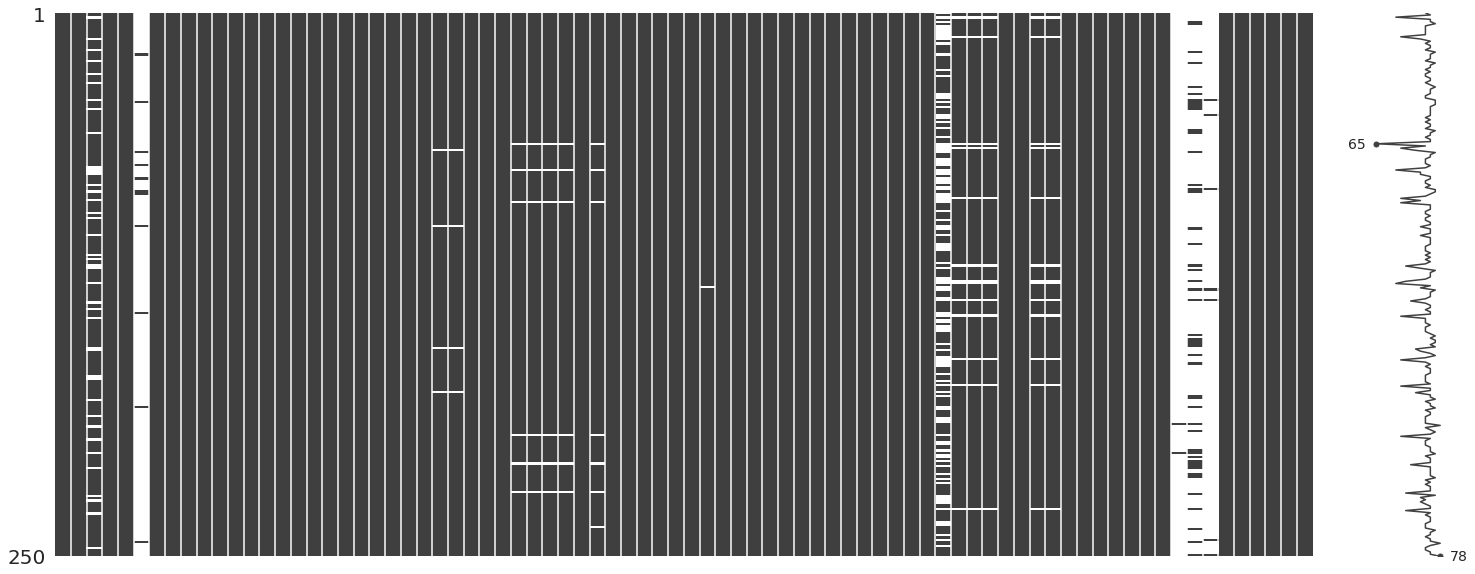

In [10]:
msno.matrix(train.sample(250));

**Nullity correlation: how strongly the presence or absence of one variable affects the presence of another**

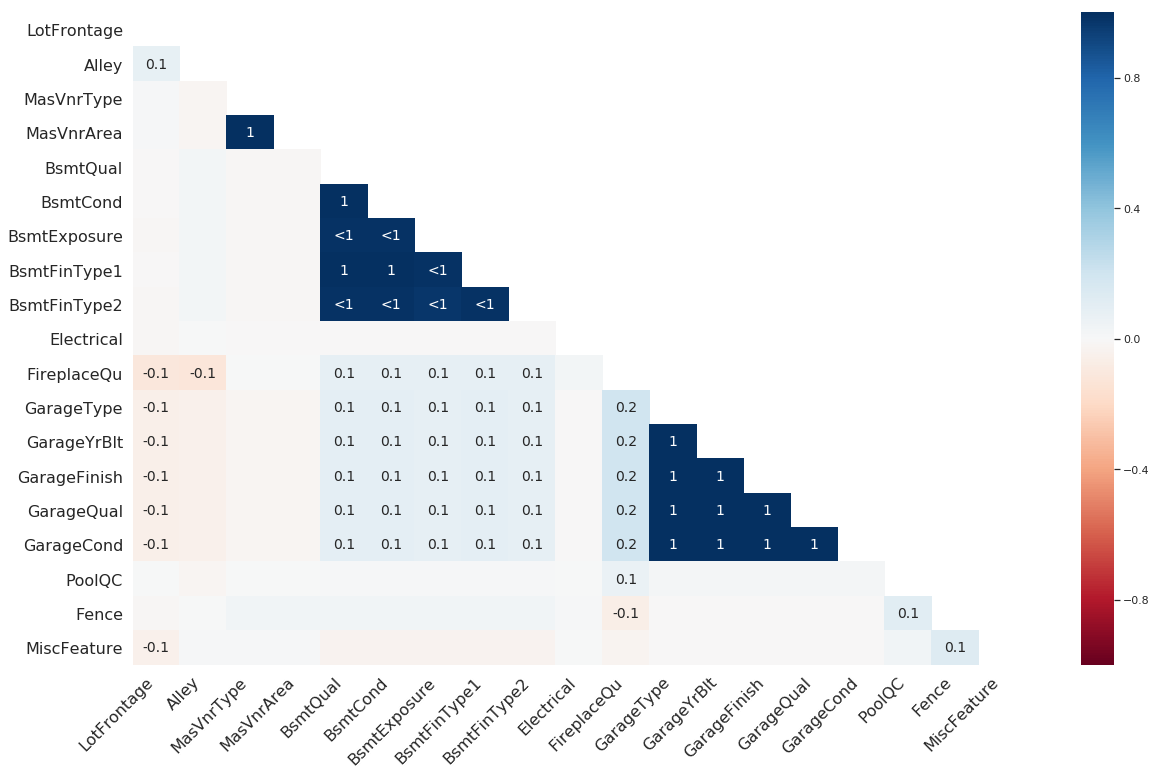

In [11]:
msno.heatmap(train);

**Plot missing values**

In [12]:
train_null = pd.DataFrame(train.isnull().sum()[train.isnull().sum() > 0].
                          sort_values(ascending=False), 
                          columns = ['missing'])

test_null = pd.DataFrame(test.isnull().sum()[test.isnull().sum() > 0].
                         sort_values(ascending=False), 
                         columns = ['missing'])



**Barchart: NaN in test and train**

In [13]:
trace1 = go.Bar(x = train_null.index, 
                y = train_null['missing'],
                name='train', 
                text = train_null.index)

trace2 = go.Bar(x = test_null.index, 
                y = test_null['missing'],
                name='test', 
                text = test_null.index)

data = [trace1, trace2]

layout = dict(title = 'NaN in test and train', 
              xaxis=dict(ticklen=10, zeroline= False),
              yaxis=dict(title = 'number of rows', side='left', ticklen=10),                                  
              legend=dict(orientation='v', x=1.05, y=1.0),
              autosize=True,
              barmode='group'
              )

fig = dict(data = data, layout = layout)
iplot(fig)

## Feature correlation

In [14]:
correlation = train.select_dtypes(include=[np.number]).corr()

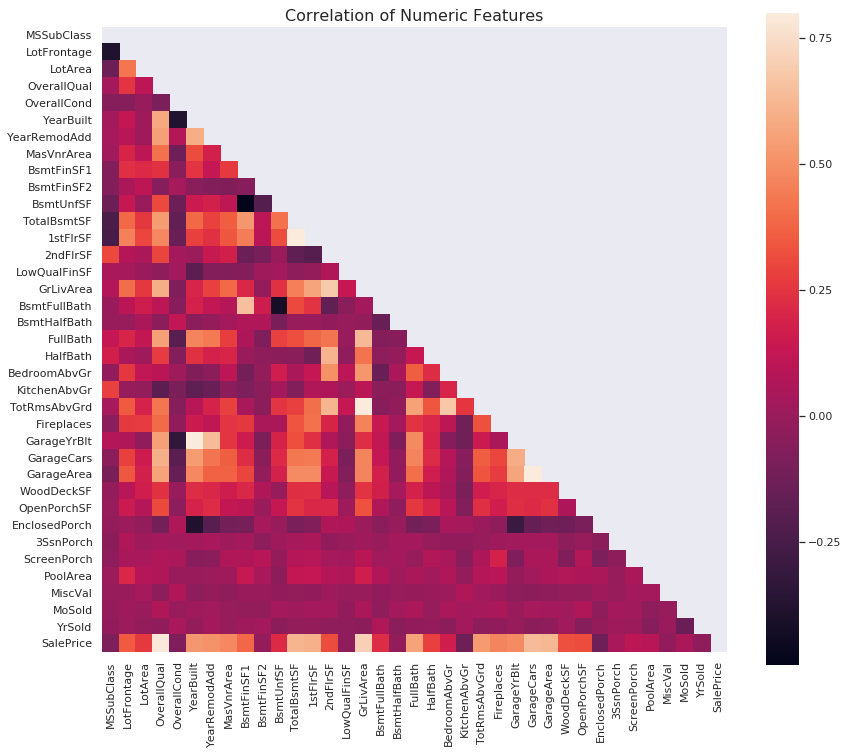

In [15]:
fig, axes = plt.subplots(figsize = (14, 12))

plt.title('Correlation of Numeric Features', size=16)

mask = np.zeros_like(correlation)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style('white'):
    sns.heatmap(correlation, square = True, vmax=0.8, mask=mask);

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt'],
      dtype='object')


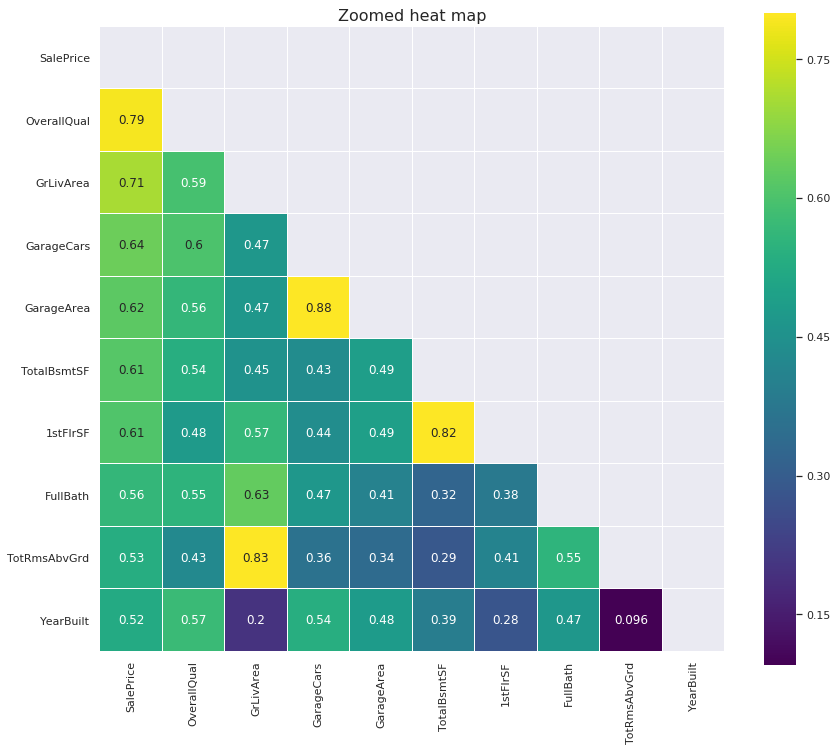

In [16]:
k = 10
cols = correlation.nlargest(k,'SalePrice')['SalePrice'].index
print(cols)

cm = np.corrcoef(train[cols].values.T)
fig, axes = plt.subplots(figsize = (14,12))

mask = np.zeros_like(cm)
mask[np.triu_indices_from(mask)] = True

plt.title('Zoomed heat map', size=16)

with sns.axes_style("white"):
    sns.heatmap(cm, vmax=.8, linewidths=0.01, square=True, annot=True, cmap='viridis',
            linecolor='white', xticklabels = cols, annot_kws = {'size':12}, yticklabels = cols, mask=mask);

In [17]:
matrix_size = train.select_dtypes(include=[np.object]).shape[1]
cmatrix = pd.DataFrame(np.zeros((matrix_size, matrix_size)), 
                       columns = categorical_columsns,
                       index = categorical_columsns)

for i in range(matrix_size):
    for j in range(matrix_size):
        confusion_matrix = pd.crosstab(train.iloc[:, i], train.iloc[:, j]).as_matrix()
        cmatrix.iloc[i, j] = cramers_v(confusion_matrix)

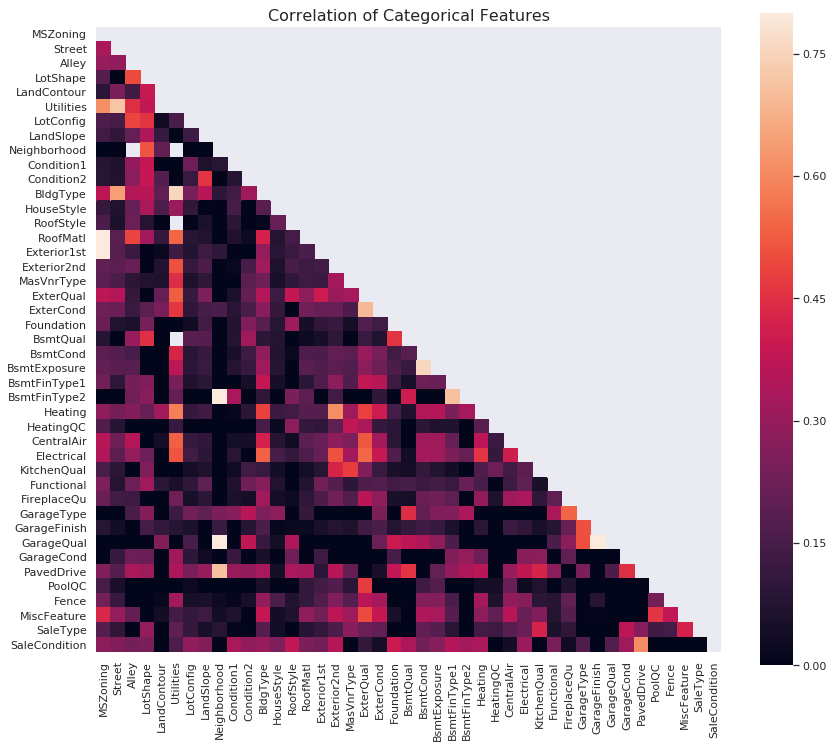

In [18]:
fig, axes = plt.subplots(figsize = (14, 12))

plt.title('Correlation of Categorical Features', size=16)

mask = np.zeros_like(cmatrix)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style('white'):
    sns.heatmap(cmatrix, square = True, vmax=0.8, mask=mask);


Distribution of SalePrice with respect to categorical features


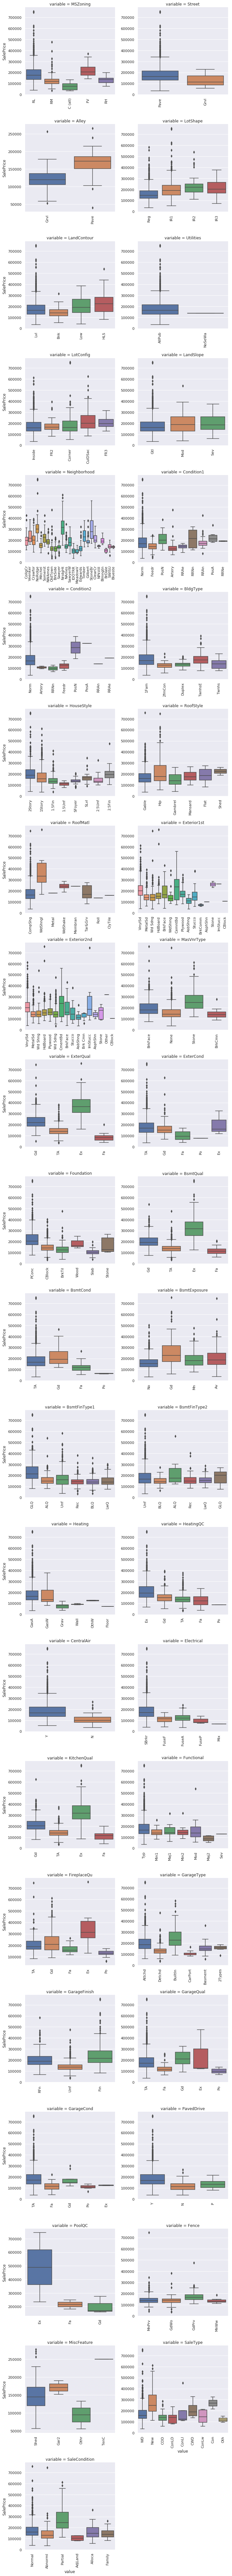

In [19]:
f = pd.melt(train, id_vars=['SalePrice'], value_vars=categorical_columsns)
g = sns.FacetGrid(f, col='variable',  col_wrap=2, sharex=False, sharey=False, size=5)
print('Distribution of SalePrice with respect to categorical features')
g = g.map(boxplot, 'value', 'SalePrice')

## Handling missing values

In [20]:
X_train = train.copy()
y_train = X_train[['SalePrice']]
X_train.drop(['SalePrice'], axis=1, inplace=True)
X_test = test.copy()

### Categorical features

In [21]:
imp_cat = SimpleImputer(missing_values=np.nan, 
                        strategy='constant', 
                        fill_value='no' + categorical_columsns)

X_train[categorical_columsns] = imp_cat.fit_transform(X_train[categorical_columsns])
X_test[categorical_columsns] = imp_cat.transform(X_test[categorical_columsns])

### Numerical features

In [22]:
imp_num= SimpleImputer(missing_values=np.nan, 
                        strategy='mean')

X_train[numerical_columns] = imp_num.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = imp_num.transform(X_test[numerical_columns])

In [23]:
print('Missing values X_train: ' + 
      str(X_train.isnull().sum()[X_train.isnull().sum() > 0].size))

print('Missing values X_test: ' + 
      str(X_test.isnull().sum()[X_test.isnull().sum() > 0].size))


Missing values X_train: 0
Missing values X_test: 0


## Feature normalization

### Visualizations of target

**Skewness and Kurtosis of target**

In [24]:
print('Skewness: {:.4}'.format(y_train.skew()[0]))
print('Kurtosis: {:.4}'.format(y_train.kurt()[0]))

Skewness: 1.883
Kurtosis: 6.536


**Target distributions**

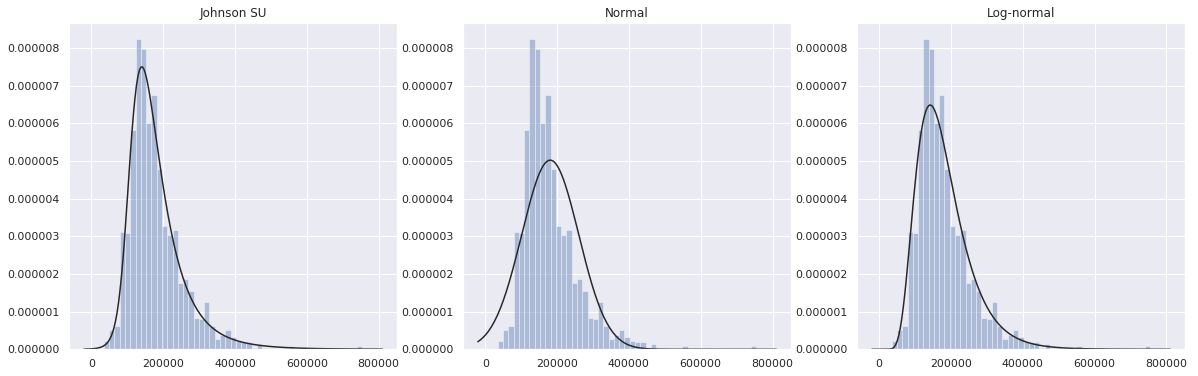

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

axes[0].set_title('Johnson SU')
axes[1].set_title('Normal')
axes[2].set_title('Log-normal')
sns.distplot(y_train, kde=False, fit=st.johnsonsu, ax=axes[0]);
sns.distplot(y_train, kde=False, fit=st.norm, ax=axes[1]);
sns.distplot(y_train, kde=False, fit=st.lognorm, ax=axes[2]);

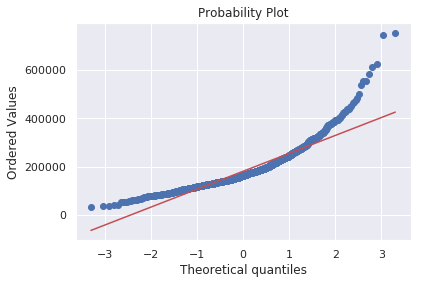

In [26]:
st.probplot(y_train.iloc[:, 0], plot=plt);

In [27]:
st.shapiro(y_train)

(0.869671642780304, 3.206247534576162e-33)

**Make target normal again**

In [28]:
pt_target = PowerTransformer(method='yeo-johnson')
y_train['SalePrice'] = pt_target.fit_transform(y_train)
st.shapiro(y_train)

(0.9915345311164856, 1.9075591239925416e-07)

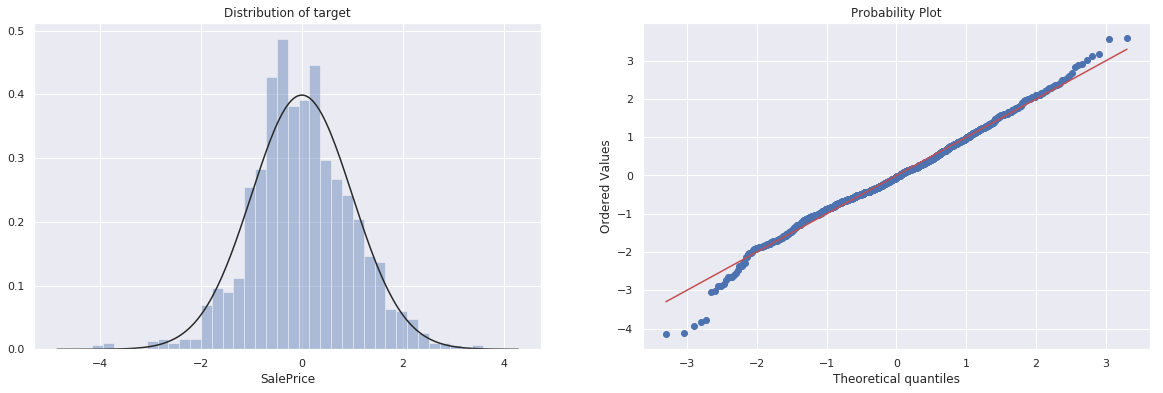

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

axes[0].set_title('Distribution of target')
sns.distplot(y_train['SalePrice'], kde=False, fit=st.norm, ax=axes[0]);
st.probplot(y_train['SalePrice'], plot=axes[1]);

### Normalize numeric features

In [30]:
pt_feat = PowerTransformer(method='yeo-johnson')
scaler = StandardScaler()
robust = RobustScaler()
frame_list = gauss_like([X_train, X_test], [pt_feat, scaler])
X_train, X_test = frame_list[0], frame_list[1]

Transformed columns: 
MSSubClass, LotFrontage, LotArea, OverallQual, OverallCond, YearBuilt, YearRemodAdd, MasVnrArea, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, 1stFlrSF, LowQualFinSF, GrLivArea, BedroomAbvGr, TotRmsAbvGrd, GarageYrBlt, GarageCars, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, MiscVal, MoSold, YrSold
Scaled columns: 
BsmtFinSF1, 2ndFlrSF, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, KitchenAbvGr, Fireplaces, GarageArea, WoodDeckSF, PoolArea


Distribution of SalePrice with respect to categorical features


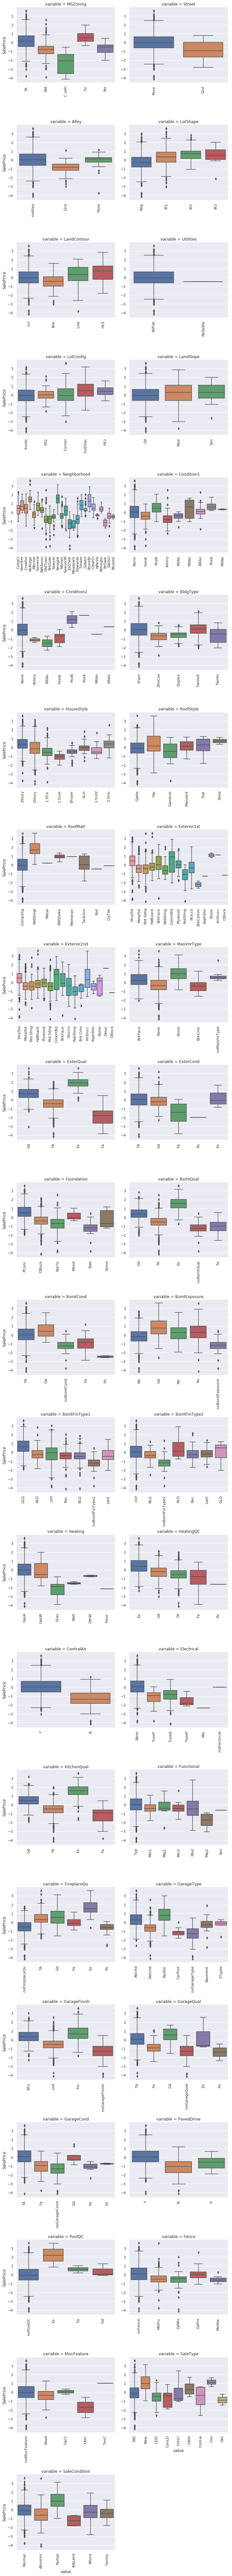

In [31]:
f = pd.melt(pd.concat([X_train, y_train], axis=1), id_vars=['SalePrice'], value_vars=categorical_columsns)
g = sns.FacetGrid(f, col='variable',  col_wrap=2, sharex=False, sharey=False, size=5)
print('Distribution of SalePrice with respect to categorical features')
g = g.map(boxplot, 'value', 'SalePrice')

## Encoding categorical data

In [32]:
onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

X_train = pd.concat([X_train[numerical_columns], 
                     pd.DataFrame(onehot_encoder.
                                  fit_transform(X_train[categorical_columsns]), 
                                  index=X_train.index)], 
                    axis=1)

X_test = pd.concat([X_test[numerical_columns], 
                     pd.DataFrame(onehot_encoder.
                                  transform(X_test[categorical_columsns]), 
                                  index=X_test.index)], 
                    axis=1)

# Modelling

We use modified cross_val_score with suffled data before splitting.

## Base models

### LASSO Regression:

In [33]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=42))

### Elastic Net Regression:

In [34]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=42))

### Kernel Ridge Regression:

In [35]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

### Gradient Boosting Regression:

With huber loss that makes it robust to outliers

In [36]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state=42)

### XGBoost:

In [37]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state=42, nthread = -1)

### LightGBM:

In [38]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

### Base models scores

In [39]:
score = rmsle_cv(lasso, X_train, y_train)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.3238 (0.0486)



In [40]:
score = rmsle_cv(ENet, X_train, y_train)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.3238 (0.0478)



In [41]:
score = rmsle_cv(KRR, X_train, y_train)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.3123 (0.0381)



In [42]:
score = rmsle_cv(GBoost, X_train, y_train)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.3124 (0.0318)



In [43]:
score = rmsle_cv(model_xgb, X_train, y_train)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.3046 (0.0265)



In [44]:
score = rmsle_cv(model_lgb, X_train, y_train)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 0.3141 (0.0232)

